In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
import itertools
import requests
import io
from pybaseball.statcast_batter import statcast_batter_bat_tracking, statcast_batter_expected_stats
from pybaseball.statcast import statcast
from pybaseball import cache
cache.enable()

# 1. Get Tracking Data
df = statcast_batter_bat_tracking(2025, minSwings='q')
df = df[['id', 'name', 'attack_angle', 'swing_tilt']]
df = df.rename(columns={'id': 'batter'})

'''
aa = pd.read_csv("EVI_CQ.csv", usecols=["batter","Name","Year","AA_Rnk"])
vba = pd.read_csv("VBA_All.csv", usecols=["batter","2023"])
sav = pd.read_csv("statcast.csv")
dfpitch = pd.read_csv("pstatcast.csv")

aa = aa[aa['Year'] == 2023]
vba = vba.dropna()
aa=aa.dropna()

df = pd.merge(aa, vba, on="batter", how="inner")
df.rename(columns={"2023": "VBA"}, inplace=True)
'''

print(df.head())

   batter              name  attack_angle  swing_tilt
0  665833       Cruz, Oneil      9.173858   33.448673
1  691406  Caminero, Junior      7.981592   26.205743
2  691023    Walker, Jordan      6.175582   31.415359
3  666176         Adell, Jo      7.995368   33.829990
4  656941   Schwarber, Kyle     14.573285   30.313744


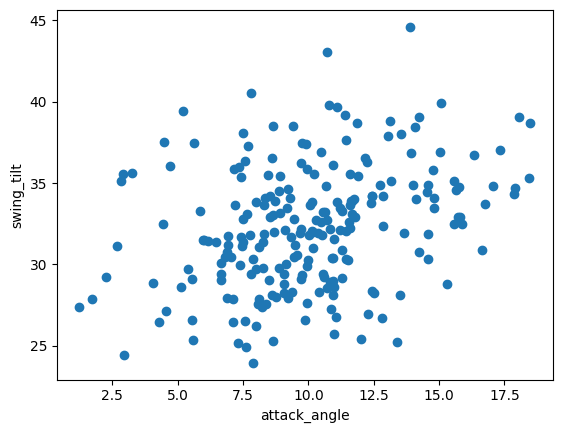

In [2]:
#Scatter VBA and AA
plt.scatter(df["attack_angle"], df["swing_tilt"])
plt.xlabel("attack_angle")
plt.ylabel("swing_tilt")
plt.show()

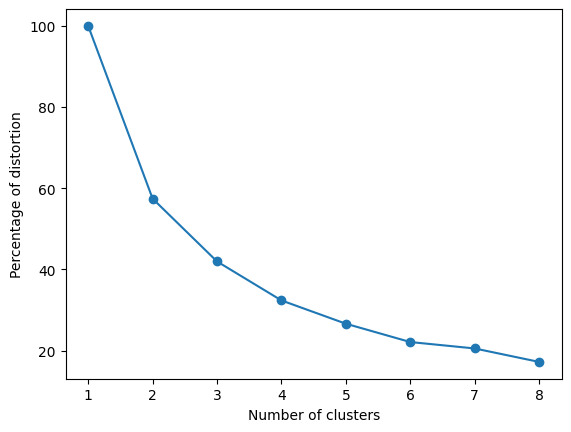

In [3]:
#K mean clustering
data = df[["attack_angle", "swing_tilt"]].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
distortions = []

for i in range(1, 9):
            kmeans = KMeans(n_clusters=i, random_state=6740, n_init='auto')
            kmeans.fit(scaled_data)
            distortions.append(kmeans.inertia_)

#plot elbow curve
max_distortion = distortions[0]
percentage_distortions = [(d / max_distortion) * 100 for d in distortions]
plt.plot(range(1, 9), percentage_distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of distortion')
plt.show()

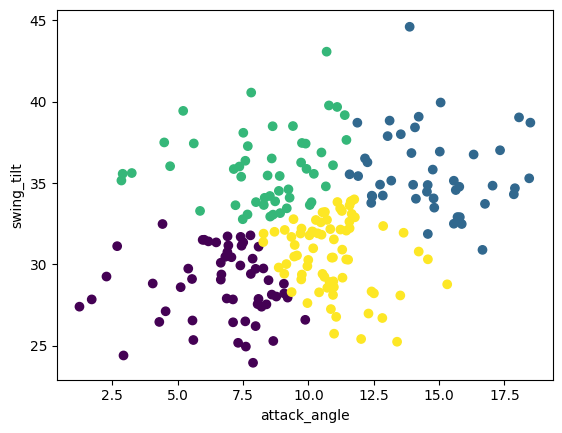

   batter              name  attack_angle  swing_tilt  cluster
0  665833       Cruz, Oneil      9.173858   33.448673        2
1  691406  Caminero, Junior      7.981592   26.205743        0
2  691023    Walker, Jordan      6.175582   31.415359        0
3  666176         Adell, Jo      7.995368   33.829990        2
4  656941   Schwarber, Kyle     14.573285   30.313744        3


In [4]:
kmeans = KMeans(n_clusters=4, random_state=6740, n_init='auto')
df['cluster'] = kmeans.fit_predict(scaled_data)
plt.scatter(df['attack_angle'], df['swing_tilt'], c=df['cluster'])
plt.xlabel('attack_angle')
plt.ylabel('swing_tilt')
plt.show()

df['cluster'] = kmeans.fit_predict(scaled_data)
print(df.head())

In [5]:
zone_mapping = {
        1: 'high',
        2: 'high',
        3: 'high',
        4: 'middle',
        5: 'middle',
        6: 'middle',
        7: 'low',
        8: 'low',
        9: 'low',
        11: 'up&in',
        12: 'up&away',
        13: 'low&in',
        14: 'low&away'}
        
d1 = statcast(start_dt='2025-01-01', end_dt='2025-12-06', verbose=False)
useful = ['pitch_type','batter','pitcher','zone','stand','p_throws','type','estimated_woba_using_speedangle']
df1 = d1[useful]
df1 = df1[df1['type']=='X']
df1 = df1[df1['batter'].isin(df['batter'])] 
print(df1.head())
print(df1.shape)

dfpitch = statcast(start_dt='2025-01-01', end_dt='2025-12-02', verbose=False)
useful_pitch = ['pitch_type','batter','pitcher','zone','stand','p_throws']
dfpitch = dfpitch[useful_pitch]
dfpitch = dfpitch[dfpitch['p_throws']=='R']
dfpitch = dfpitch[dfpitch['stand']=='R']
dfpitch['remapped_zone'] = dfpitch['zone'].map(zone_mapping)
print(dfpitch.head())


100%|██████████| 246/246 [00:09<00:00, 26.81it/s]


    pitch_type  batter  pitcher  zone stand p_throws type  \
42          FS  672386   808967     6     R        R    X   
75          CU  643396   808967     6     R        R    X   
80          FF  665489   808967    11     R        R    X   
210         CH  518692   669456     5     L        R    X   
298         SL  669257   669456     5     R        R    X   

     estimated_woba_using_speedangle  
42                             0.029  
75                              <NA>  
80                              0.31  
210                            0.317  
298                         0.870154  
(89778, 8)


100%|██████████| 246/246 [00:08<00:00, 30.50it/s]


   pitch_type  batter  pitcher  zone stand p_throws remapped_zone
42         FS  672386   808967     6     R        R        middle
47         CU  672386   808967     4     R        R        middle
49         FC  672386   808967     9     R        R           low
75         CU  643396   808967     6     R        R        middle
80         FF  665489   808967    11     R        R         up&in


In [6]:
#take mean estimated_woba grouped by batter, pitch_type, p_throws
df2 = df1.groupby(['batter', 'pitch_type', 'p_throws']).agg(
    pitch_xWOBACON=('estimated_woba_using_speedangle', 'mean'),  # Calculate mean
    count=('estimated_woba_using_speedangle', 'size')  # Calculate count
).reset_index()

batter_agg = df1.groupby('batter').agg(
            season_xWOBACON=('estimated_woba_using_speedangle', 'mean'),
            batter_count=('estimated_woba_using_speedangle', 'size')
        ).reset_index()

df2 = pd.merge(df2, batter_agg, on='batter', how='left')


#remove rows with count less than 10, only RHP
df2 = df2[df2['p_throws']=='R']
df2 = df2[df2['count'] >= 10]
df3 = pd.merge(df2, df, on="batter", how="left")
print(df3.head(3))

dfzone = df1.groupby(['batter', 'zone', 'p_throws']).agg(
    pitch_xWOBACON=('estimated_woba_using_speedangle', 'mean'),  # Calculate mean
    count=('estimated_woba_using_speedangle', 'size')  # Calculate count
).reset_index()

dfzone = pd.merge(dfzone, batter_agg, on='batter', how='left')
dfzone = pd.merge(dfzone, df, on="batter", how="left")
dfzone = dfzone[dfzone['p_throws']=='R']
dfzone = dfzone[dfzone['count'] >= 10]
dfzone.head()

print(dfzone.head())

   batter pitch_type p_throws  pitch_xWOBACON  count  season_xWOBACON  \
0  457705         CH        R        0.349171     10         0.379056   
1  457705         CU        R        0.346391     17         0.379056   
2  457705         FC        R        0.393462     13         0.379056   

   batter_count               name  attack_angle  swing_tilt  cluster  
0           373  McCutchen, Andrew     14.536913   34.466935        1  
1           373  McCutchen, Andrew     14.536913   34.466935        1  
2           373  McCutchen, Andrew     14.536913   34.466935        1  
    batter  zone p_throws  pitch_xWOBACON  count  season_xWOBACON  \
1   457705     1        R        0.333947     20         0.379056   
3   457705     2        R        0.391105     13         0.379056   
7   457705     4        R        0.356743     31         0.379056   
9   457705     5        R        0.355033     44         0.379056   
11  457705     6        R          0.4275     36         0.379056   

    

In [7]:


data = statcast_batter_expected_stats(2025)
data = data[['player_id','est_woba']]

#merge
#df3 = pd.merge(df3, data, left_on='batter', right_on='player_id', how='left')

#rename
df4 = df3.rename(columns={'batter': 'player_id'})
df4['delta'] = df4['pitch_xWOBACON'] - df4['season_xWOBACON'] #positive value means player performed better than expected against this pitch
df4.head()

dfzone = dfzone.rename(columns={'batter': 'player_id'})
dfzone['delta'] = dfzone['pitch_xWOBACON'] - dfzone['season_xWOBACON'] #positive value means player performed better than expected against this pitch
dfzone.head()

,player_id,zone,p_throws,pitch_xWOBACON,count,season_xWOBACON,batter_count,name,attack_angle,swing_tilt,cluster,delta
1,457705,1,R,0.333947,20,0.379056,373,"McCutchen, Andrew",14.536913,34.466935,1,-0.045109
3,457705,2,R,0.391105,13,0.379056,373,"McCutchen, Andrew",14.536913,34.466935,1,0.012049
7,457705,4,R,0.356743,31,0.379056,373,"McCutchen, Andrew",14.536913,34.466935,1,-0.022313
9,457705,5,R,0.355033,44,0.379056,373,"McCutchen, Andrew",14.536913,34.466935,1,-0.024023
11,457705,6,R,0.4275,36,0.379056,373,"McCutchen, Andrew",14.536913,34.466935,1,0.048444


In [8]:
#plot delta based on pitch_type and cluster
df4['dif'] = df4['delta'] * df4['count']
dfzone['dif'] = dfzone['delta'] * dfzone['count']

#sum dif grouping by cluster and pitch type
grouped_df = df4.groupby(['pitch_type', 'cluster']).agg(
            average_delta=('delta', 'mean'),  # Calculate the mean of delta
            sample_size=('count', 'sum') #Sum the count column.
        ).reset_index()

grouped_df.head()

zonegrouped_df = dfzone.groupby(['zone', 'cluster']).agg(
            average_delta=('delta', 'mean'),  # Calculate the mean of delta
            sample_size=('count', 'sum') #Sum the count column.
        ).reset_index()
zonegrouped_df.head()



,zone,cluster,average_delta,sample_size
0,1,0,-0.009355,866
1,1,1,-0.043558,520
2,1,2,-0.05401,574
3,1,3,-0.004207,1008
4,2,0,0.027753,1218


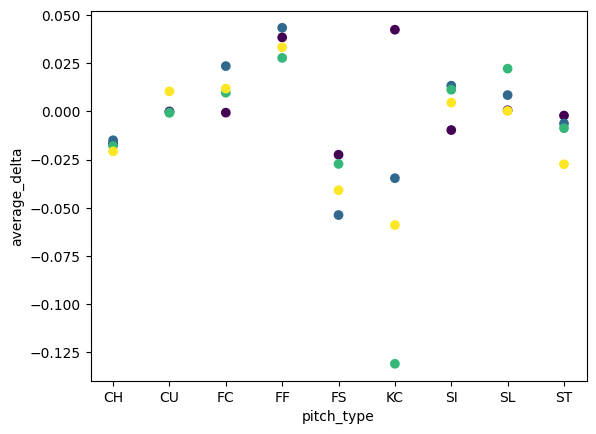

In [9]:
#scatter average_delta on y axis, pitch_type on x axis, with cluster setting the color
plt.scatter(grouped_df['pitch_type'], grouped_df['average_delta'], c=grouped_df['cluster'])
plt.xlabel('pitch_type')
plt.ylabel('average_delta')
plt.show()

In [10]:

def perform_anova_on_raw_data(df4):
    results = {}
    for pitch_type, pitch_data in df4.groupby('pitch_type'):
        clusters = pitch_data['cluster'].unique()

        # Check if there are enough clusters for ANOVA
        if len(clusters) < 2:
            results[pitch_type] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "less than 2 clusters"}])
            continue

        delta_groups = []
        for cluster in clusters:
            delta_values = pitch_data[pitch_data['cluster'] == cluster]['delta'].values # delta instead of average_delta
            delta_groups.append(delta_values)

        # Perform ANOVA
        try:
            f_stat, p_value = stats.f_oneway(*delta_groups)
            results[pitch_type] = pd.DataFrame([{
                'f_statistic': f_stat,
                'p_value': p_value
            }])
        except ValueError as e:
            results[pitch_type] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"ValueError: {e}"}])
            print(f"ValueError for {pitch_type}: {e}")
            print(f"Delta groups: {delta_groups}")
        except Exception as e:
            results[pitch_type] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"Exception: {e}"}])
            print(f"Exception for {pitch_type}: {e}")
            print(f"Delta groups: {delta_groups}")

    return results

anova_results = perform_anova_on_raw_data(df4)

formatted_data = []
for pitch_type, results_df in anova_results.items():
    if not results_df.empty:
      f_statistic = results_df['f_statistic'].iloc[0]
    p_value = results_df['p_value'].iloc[0]
    formatted_data.append({
      'pitch_type': pitch_type,
      'f_statistic': f_statistic,
      'p_value': p_value
    })
print(pd.DataFrame(formatted_data))

  pitch_type  f_statistic   p_value
0         CH     0.057150  0.982005
1         CU     0.176927  0.911931
2         FC     0.566012  0.637968
3         FF     1.338588  0.262675
4         FS     0.691839  0.558630
5         KC     1.703756  0.242963
6         SI     1.416602  0.238758
7         SL     1.268630  0.285987
8         ST     0.636323  0.592680


In [11]:

def perform_anova_on_raw_zone_data(df):
    results = {}
    for zone, zone_data in df.groupby('zone'):
        clusters = zone_data['cluster'].unique()

        # Check if there are enough clusters for ANOVA
        if len(clusters) < 2:
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "less than 2 clusters"}])
            continue

        delta_groups = []
        for cluster in clusters:
            delta_values = zone_data[zone_data['cluster'] == cluster]['delta'].values  # Corrected line
            delta_groups.append(delta_values)

        # Check for empty delta groups
        if any(len(group) == 0 for group in delta_groups):
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "Empty delta group"}])
            continue

        # Check for single unique value in delta groups
        unique_values = [np.unique(group) for group in delta_groups]
        if any(len(values) == 1 for values in unique_values):
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "One or more delta groups have only 1 unique value"}])
            continue

        # Perform ANOVA
        try:
            f_stat, p_value = stats.f_oneway(*delta_groups)
            results[zone] = pd.DataFrame([{
                'f_statistic': f_stat,
                'p_value': p_value
            }])
        except ValueError as e:
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"ValueError: {e}"}])
            print(f"ValueError for zone {zone}: {e}")
            print(f"Delta groups: {delta_groups}")
        except Exception as e:
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"Exception: {e}"}])
            print(f"Exception for zone {zone}: {e}")
            print(f"Delta groups: {delta_groups}")

    return results

anova_results = perform_anova_on_raw_zone_data(dfzone)

formatted_results = pd.DataFrame()
for zone, result_df in anova_results.items():
    result_df['zone'] = zone
    formatted_results = pd.concat([formatted_results, result_df], ignore_index=True)

print(formatted_results)

    f_statistic   p_value  zone
0      2.180578  0.092149     1
1      0.454283  0.714545     2
2      0.279166  0.840362     3
3      0.283894  0.837002     4
4      1.480435  0.220707     5
5      0.658660  0.578310     6
6      0.213956  0.886657     7
7      0.608813  0.609931     8
8      2.338103  0.074797     9
9      1.626081  0.187291    11
10     4.898662  0.003876    12
11     1.119484  0.342853    13
12     0.493771  0.687154    14


In [12]:
zone_mapping = {
        1: 'high',
        2: 'high',
        3: 'high',
        4: 'middle',
        5: 'middle',
        6: 'middle',
        7: 'low',
        8: 'low',
        9: 'low',
        11: 'up&in',
        12: 'up&away',
        13: 'low&in',
        14: 'low&away'}

dfzone['zone'] = dfzone['zone'].map(zone_mapping)

anova_results = perform_anova_on_raw_zone_data(dfzone)

formatted_results = pd.DataFrame()
for zone, result_df in anova_results.items():
    result_df['zone'] = zone
    formatted_results = pd.concat([formatted_results, result_df], ignore_index=True)

print(formatted_results)

   f_statistic   p_value      zone
0     0.379298  0.767971      high
1     1.445316  0.228477       low
2     0.493771  0.687154  low&away
3     1.119484  0.342853    low&in
4     0.961572  0.410389    middle
5     4.898662  0.003876   up&away
6     1.626081  0.187291     up&in


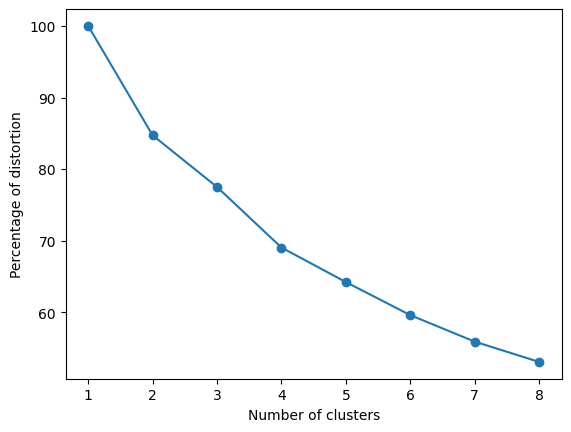

In [13]:
pitcher_zone_counts = dfpitch.groupby(['pitcher', 'remapped_zone']).size().reset_index(name='pitch_count')
pivot_df = pitcher_zone_counts.pivot(index='pitcher', columns='remapped_zone', values='pitch_count').fillna(0)
normalized_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(normalized_df)

distortions = []
for i in range(1, 9):
            kmeans = KMeans(n_clusters=i, random_state=6740, n_init='auto')
            kmeans.fit(scaled_data)
            distortions.append(kmeans.inertia_)

#plot elbow curve
max_distortion = distortions[0]
percentage_distortions = [(d / max_distortion) * 100 for d in distortions]
plt.plot(range(1, 9), percentage_distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of distortion')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=6, random_state=6740, n_init=10) # Added n_init for future warning
normalized_df['cluster'] = kmeans.fit_predict(scaled_data)
normalized_df.reset_index() # Include pitcher in the output
print(normalized_df.head())

#now get xwobacon or xwoba for hitter/pitcher matchups per cluster and see if noticiable performanace difference

remapped_zone      high       low  low&away    low&in    middle   up&away  \
pitcher                                                                     
434378         0.168506  0.120677  0.242090  0.036792  0.208241  0.116998   
445276         0.175055  0.161926  0.113786  0.056893  0.269147  0.054705   
445926         0.094828  0.189655  0.275862  0.060345  0.258621  0.060345   
450203         0.101375  0.219931  0.281787  0.070447  0.187285  0.060137   
453286         0.124679  0.188946  0.282776  0.069409  0.209512  0.042416   

remapped_zone     up&in  cluster  
pitcher                           
434378         0.106696        5  
445276         0.168490        5  
445926         0.060345        1  
450203         0.079038        1  
453286         0.082262        1  


In [15]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

#get silhouette score and davies bouldin index
features = normalized_df[['high','low','middle','low&away','low&in','up&away','up&in']] # Use double brackets to select multiple columns
labels = normalized_df['cluster']
silhouette_avg = silhouette_score(features, labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")

db_index = davies_bouldin_score(features, labels)
print(f"Davies-Bouldin Index: {db_index:.3f}")

Silhouette Score: 0.145
Davies-Bouldin Index: 1.490


In [16]:
#h v p mathcups
#merge to get  clusters
dfm = pd.merge(df1, normalized_df, left_on='pitcher', right_on='pitcher', how='inner')
dfm = dfm.rename(columns={'cluster': 'pitcher_cluster'})
dfm = pd.merge(dfm, dfzone, left_on='batter', right_on='player_id', how='inner')
dfm = dfm.rename(columns={'cluster': 'batter_cluster'})
dfm = dfm.dropna(subset=['batter_cluster','pitcher_cluster'])
dfm = dfm[['batter','pitcher','pitcher_cluster','batter_cluster','pitch_xWOBACON','season_xWOBACON']]

#get difference in woba,
dfm['delta'] = dfm['pitch_xWOBACON'] - dfm['season_xWOBACON']


dfm['pitcher_cluster'] = dfm['pitcher_cluster'].astype('category')
dfm['batter_cluster'] = dfm['batter_cluster'].astype('category')
import statsmodels.formula.api as smf

# Perform the two-way ANOVA
# 'delta' is the dependent variable
# 'pitcher_cluster' and 'batter_cluster' are the independent variables
# The 'C()' function tells statsmodels to treat them as categorical
model = smf.ols('delta ~ C(pitcher_cluster) + C(batter_cluster) + C(pitcher_cluster):C(batter_cluster)', data=dfm)
results = model.fit()

# Print the ANOVA table
print(results.summary())

# To get the actual ANOVA table in a more structured format:
import statsmodels.api as sm
anova_table = sm.stats.anova_lm(results, typ=2) # Type 2 ANOVA is generally recommended
print("\nANOVA Table:")
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.16
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           1.27e-64
Time:                        18:10:06   Log-Likelihood:             5.7988e+05
No. Observations:              702849   AIC:                        -1.160e+06
Df Residuals:                  702825   BIC:                        -1.159e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

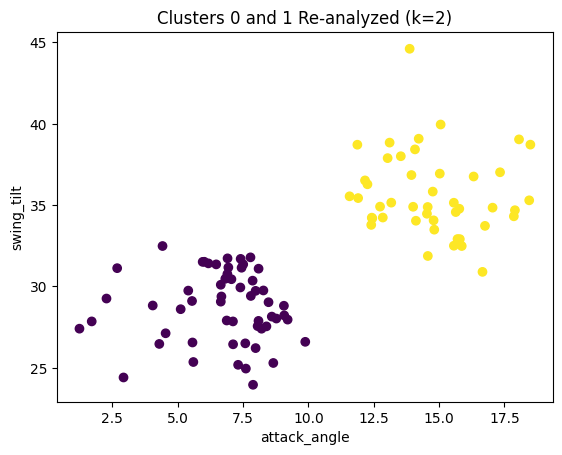

             attack_angle  swing_tilt
new_cluster                          
0                6.716747   28.764168
1               14.726227   35.637248


In [17]:
#try with first 2 clusters which are more extreme
df_subset = df[df['cluster'].isin([0, 1])].copy()

# Re-scale features
subset_data = df_subset[['attack_angle', 'swing_tilt']]
scaler_subset = StandardScaler()
scaled_subset = scaler_subset.fit_transform(subset_data)

# Apply K-means with 2 clusters
kmeans_subset = KMeans(n_clusters=2, random_state=6740, n_init='auto')
df_subset['new_cluster'] = kmeans_subset.fit_predict(scaled_subset)

# Plot the results
plt.scatter(df_subset['attack_angle'], df_subset['swing_tilt'], c=df_subset['new_cluster'])
plt.xlabel('attack_angle')
plt.ylabel('swing_tilt')
plt.title('Clusters 0 and 1 Re-analyzed (k=2)')
plt.show()

# Show the mean values
print(df_subset.groupby('new_cluster')[['attack_angle', 'swing_tilt']].mean())


--- ANOVA and Plots for Clusters 0 & 1 ---


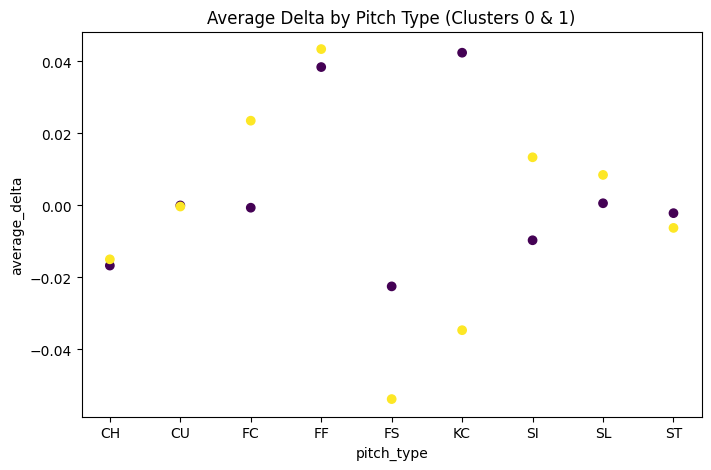


ANOVA on Raw Data (Pitch Type) for Clusters 0 & 1:
  pitch_type  f_statistic   p_value
0         CH     0.012002  0.913020
1         CU     0.000205  0.988620
2         FC     1.370335  0.244593
3         FF     0.347602  0.556817
4         FS     1.444557  0.234648
5         KC     1.014003  0.388127
6         SI     3.355299  0.069996
7         SL     0.416627  0.520134
8         ST     0.030357  0.862178

ANOVA on Raw Zone Data for Clusters 0 & 1:
   f_statistic   p_value      zone
0     0.683050  0.409384      high
1     0.202541  0.653019       low
2     0.316769  0.575380  low&away
3     3.214620  0.077565    low&in
4     2.499144  0.114962    middle
5    11.682135  0.001694   up&away
6     3.753658  0.058351     up&in

2-Way ANOVA (Pitcher Cluster x Batter Cluster) for Clusters 0 & 1:
                                           sum_sq        df           F  \
C(pitcher_cluster)                       0.083995       5.0    1.448086   
C(batter_cluster)                        1.513

In [18]:
# --- SUBSET ANALYSIS: PLOTS & ANOVA FOR CLUSTERS 0 & 1 ---
print("--- ANOVA and Plots for Clusters 0 & 1 ---")

# 1. Filter df4 and dfzone for ONLY clusters 0 and 1
df4_subset = df4[df4['cluster'].isin([0, 1])].copy()
dfzone_subset = dfzone[dfzone['cluster'].isin([0, 1])].copy()

# Recreate grouped_df for subset
grouped_df_subset = df4_subset.groupby(['pitch_type', 'cluster']).agg(
            average_delta=('delta', 'mean'),  
            sample_size=('count', 'sum') 
        ).reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(grouped_df_subset['pitch_type'], grouped_df_subset['average_delta'], c=grouped_df_subset['cluster'])
plt.xlabel('pitch_type')
plt.ylabel('average_delta')
plt.title('Average Delta by Pitch Type (Clusters 0 & 1)')
plt.show()

# Run ANOVA on raw data (pitch type)
print("\nANOVA on Raw Data (Pitch Type) for Clusters 0 & 1:")
anova_results_subset = perform_anova_on_raw_data(df4_subset)
formatted_data_subset = []
for pitch_type, results_df in anova_results_subset.items():
    if not results_df.empty:
      f_statistic = results_df['f_statistic'].iloc[0]
      p_value = results_df['p_value'].iloc[0]
      formatted_data_subset.append({
        'pitch_type': pitch_type,
        'f_statistic': f_statistic,
        'p_value': p_value
      })
print(pd.DataFrame(formatted_data_subset))

# Run ANOVA on raw zone data
print("\nANOVA on Raw Zone Data for Clusters 0 & 1:")
anova_zone_results_subset = perform_anova_on_raw_zone_data(dfzone_subset)
formatted_zone_results = pd.DataFrame()
for zone, result_df in anova_zone_results_subset.items():
    result_df['zone'] = zone
    # For conciseness, we print only the valid stats
    if result_df['f_statistic'].notnull().any():
        formatted_zone_results = pd.concat([formatted_zone_results, result_df], ignore_index=True)
print(formatted_zone_results)

# 2. Re-run 2-way ANOVA regression on subset
print("\n2-Way ANOVA (Pitcher Cluster x Batter Cluster) for Clusters 0 & 1:")
dfm_subset = dfm[dfm['batter_cluster'].isin([0, 1])].copy() 
# We must remove unused categories from the subset so the model degrees of freedom are correct
dfm_subset['batter_cluster'] = dfm_subset['batter_cluster'].cat.remove_unused_categories()

model_subset = smf.ols('delta ~ C(pitcher_cluster) + C(batter_cluster) + C(pitcher_cluster):C(batter_cluster)', data=dfm_subset)
results_subset = model_subset.fit()
anova_table_subset = sm.stats.anova_lm(results_subset, typ=2)
print(anova_table_subset)


In [26]:
zone_col = 'remapped_zone' if 'remapped_zone' in dfzone_subset.columns else 'zone'
zone_comparison = dfzone_subset.groupby([zone_col, 'cluster'])['delta'].mean().unstack()
zone_comparison['diff'] = zone_comparison[1] - zone_comparison[0]
zone_comparison['better'] = np.where(zone_comparison[1] > zone_comparison[0], 'Cluster 1', 'Cluster 0')
print(zone_comparison[['better']])


cluster      better
zone               
high      Cluster 0
low       Cluster 1
low&away  Cluster 0
low&in    Cluster 0
middle    Cluster 1
up&away   Cluster 0
up&in     Cluster 0
